<a href="https://colab.research.google.com/github/andersod55123456789/Dales_code_box/blob/main/RNN_Visualizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initializing RL Maze Learning Visualizer...
Training RL agent...
Episode 0: Reward = -66.6, Length = 32, Epsilon = 1.000
Episode 20: Reward = -64.8, Length = 32, Epsilon = 0.905
Episode 40: Reward = -68.2, Length = 32, Epsilon = 0.818
Episode 60: Reward = -62.6, Length = 32, Epsilon = 0.740
Episode 80: Reward = -66.4, Length = 32, Epsilon = 0.670
Episode 100: Reward = -57.2, Length = 32, Epsilon = 0.606
Generating RL Learning Visualization...
Generating frame for episode 1/120
Generating frame for episode 3/120
Generating frame for episode 5/120
Generating frame for episode 7/120
Generating frame for episode 9/120
Generating frame for episode 11/120
Generating frame for episode 13/120
Generating frame for episode 15/120
Generating frame for episode 17/120
Generating frame for episode 19/120
Generating frame for episode 21/120
Generating frame for episode 23/120
Generating frame for episode 25/120
Generating frame for episode 27/120
Generating frame for episode 29/120
Generating frame f

/tmp/ipython-input-96149232.py:389: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame_path)


GIF saved as rl_maze_learning.gif

✅ RL learning animation saved to: rl_maze_learning.gif

The GIF shows:
- Agent learning to navigate maze using Q-Learning
- Q-values (expected rewards) evolving over episodes
- Policy (best actions) being learned
- Exploration vs exploitation trade-off (epsilon decay)
- Episode rewards and path lengths improving
- Value function showing learned state preferences
- Learning curves with moving averages

Displaying the generated GIF:


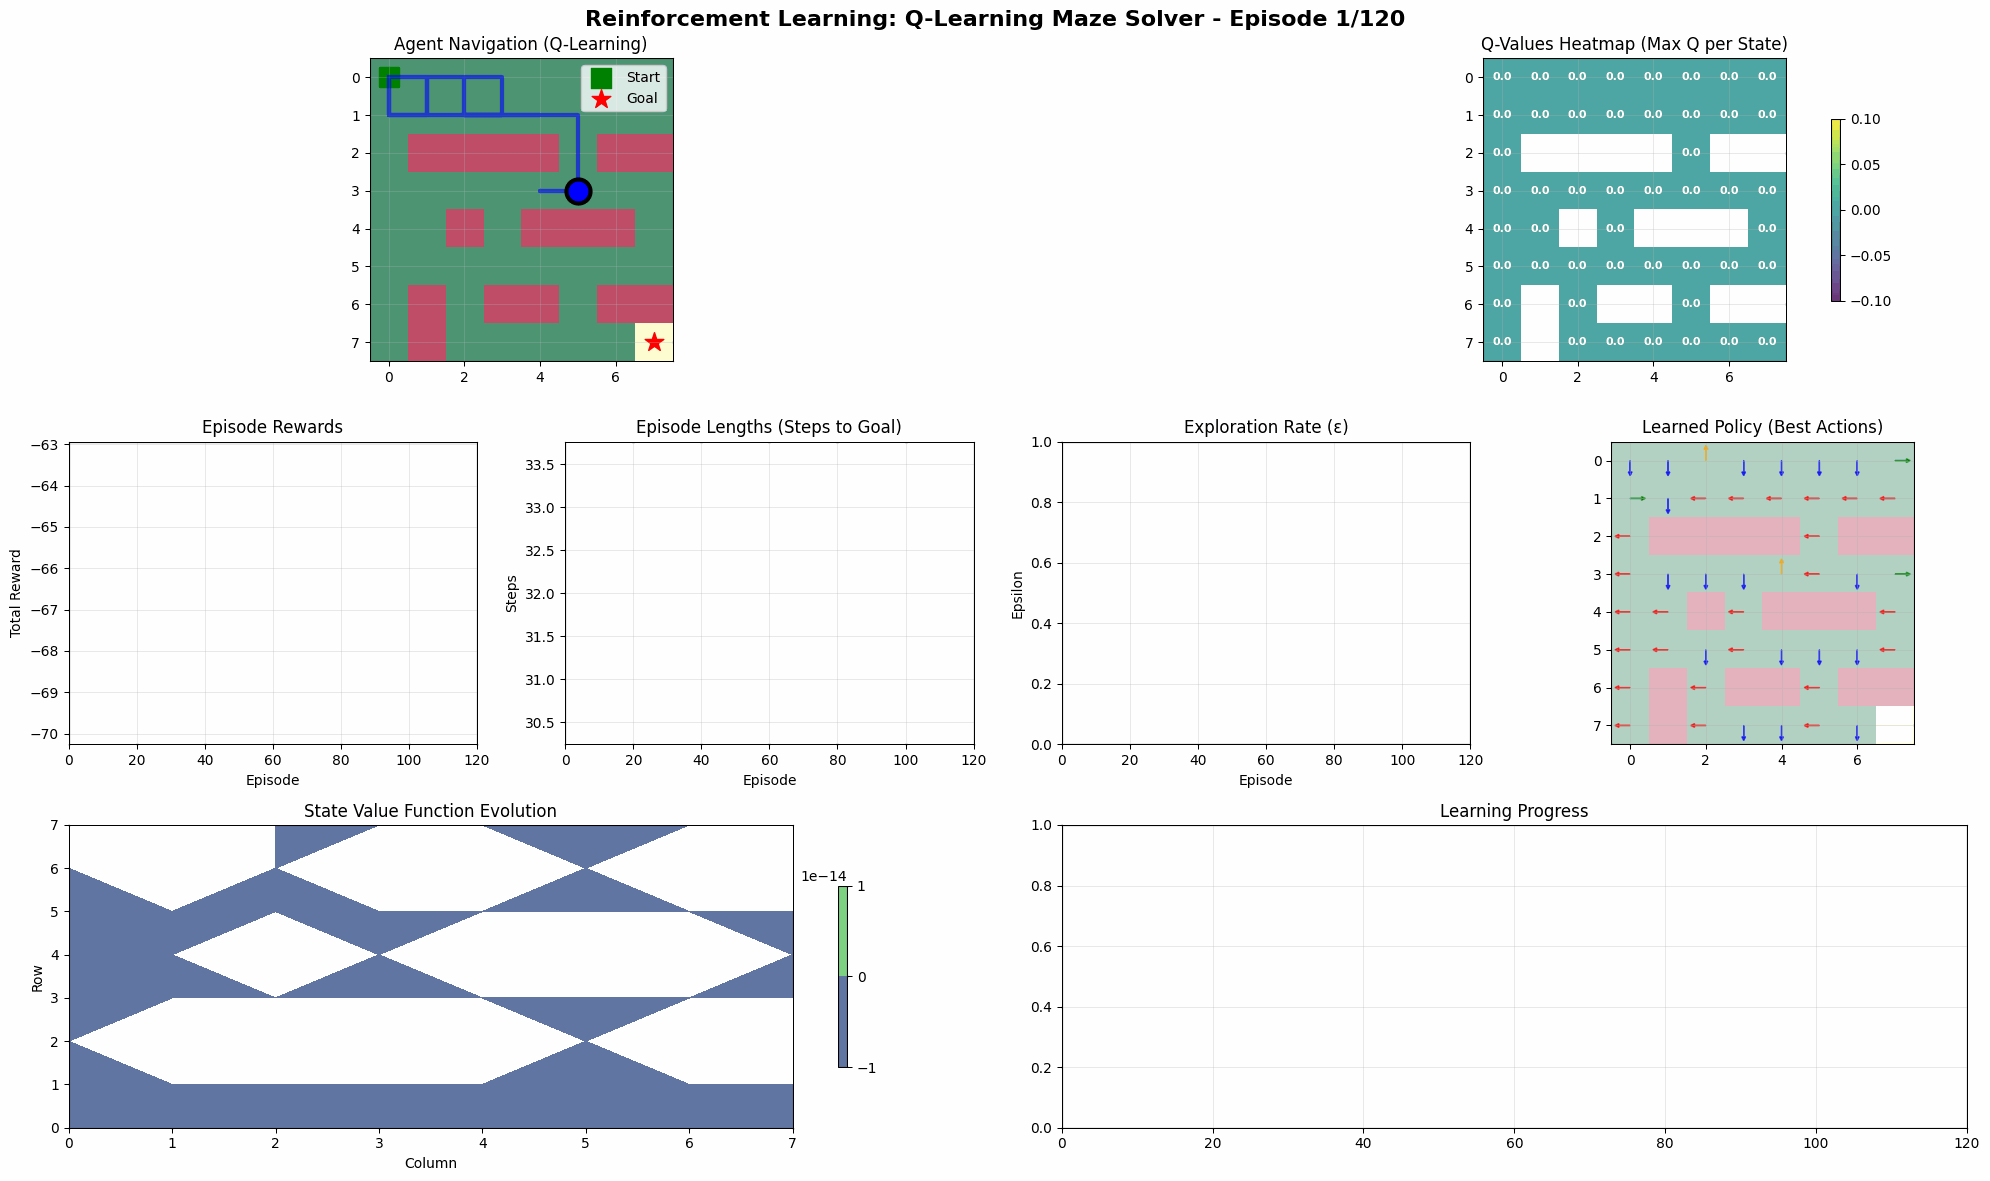

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle, Circle, Arrow
import imageio
import os
from collections import defaultdict, deque
import random

class RLMazeVisualizer:
    def __init__(self, maze_size=10, num_episodes=150):
        self.maze_size = maze_size
        self.num_episodes = num_episodes
        self.setup_maze()
        self.setup_agent()
        self.train_agent()

    def setup_maze(self):
        """Create an interesting maze with obstacles and goal"""
        self.maze = np.zeros((self.maze_size, self.maze_size))

        # Add walls (1 = wall, 0 = free space)
        # Create a maze pattern
        walls = [
            (2, 1), (2, 2), (2, 3), (2, 4), (2, 6), (2, 7),
            (4, 2), (4, 4), (4, 5), (4, 6), (4, 8),
            (6, 1), (6, 3), (6, 4), (6, 6), (6, 7), (6, 8),
            (7, 1), (8, 1), (8, 3), (8, 4), (8, 5)
        ]

        for wall in walls:
            if 0 <= wall[0] < self.maze_size and 0 <= wall[1] < self.maze_size:
                self.maze[wall] = 1

        # Set start and goal positions
        self.start_pos = (0, 0)
        self.goal_pos = (self.maze_size-1, self.maze_size-1)
        self.maze[self.goal_pos] = 2  # 2 = goal

        # Possible actions: up, right, down, left
        self.actions = [(-1, 0), (0, 1), (1, 0), (0, -1)]
        self.action_names = ['Up', 'Right', 'Down', 'Left']

    def setup_agent(self):
        """Initialize Q-learning agent"""
        # Q-table: Q[state][action] = expected future reward
        self.q_table = defaultdict(lambda: defaultdict(float))

        # Hyperparameters
        self.learning_rate = 0.1
        self.discount_factor = 0.95
        self.epsilon_start = 1.0
        self.epsilon_end = 0.01
        self.epsilon_decay = 0.995

        # Training tracking
        self.episode_rewards = []
        self.episode_lengths = []
        self.exploration_history = []
        self.q_value_history = []
        self.policy_history = []
        self.agent_paths = []

    def get_valid_actions(self, pos):
        """Get valid actions from current position"""
        valid_actions = []
        for i, action in enumerate(self.actions):
            new_pos = (pos[0] + action[0], pos[1] + action[1])
            # Check bounds and walls
            if (0 <= new_pos[0] < self.maze_size and
                0 <= new_pos[1] < self.maze_size and
                self.maze[new_pos] != 1):
                valid_actions.append(i)
        return valid_actions

    def choose_action(self, pos, epsilon):
        """Epsilon-greedy action selection"""
        valid_actions = self.get_valid_actions(pos)
        if not valid_actions:
            return None

        if random.random() < epsilon:
            # Explore: random action
            return random.choice(valid_actions)
        else:
            # Exploit: best known action
            q_values = [self.q_table[pos][action] for action in valid_actions]
            best_action_idx = np.argmax(q_values)
            return valid_actions[best_action_idx]

    def get_reward(self, pos, action, new_pos):
        """Define reward structure"""
        if new_pos == self.goal_pos:
            return 100  # Big reward for reaching goal
        elif self.maze[new_pos] == 1:
            return -10  # Penalty for hitting wall (shouldn't happen)
        else:
            # Small negative reward for each step (encourages efficiency)
            # Plus small bonus for getting closer to goal
            goal_distance = abs(new_pos[0] - self.goal_pos[0]) + abs(new_pos[1] - self.goal_pos[1])
            return -1 - 0.1 * goal_distance

    def train_agent(self):
        """Train the Q-learning agent"""
        print("Training RL agent...")

        for episode in range(self.num_episodes):
            pos = self.start_pos
            episode_reward = 0
            episode_length = 0
            path = [pos]

            # Current epsilon (decaying exploration)
            epsilon = max(self.epsilon_end,
                         self.epsilon_start * (self.epsilon_decay ** episode))

            max_steps = self.maze_size * 4  # Prevent infinite loops

            while pos != self.goal_pos and episode_length < max_steps:
                action = self.choose_action(pos, epsilon)
                if action is None:
                    break

                # Take action
                new_pos = (pos[0] + self.actions[action][0],
                          pos[1] + self.actions[action][1])

                # Get reward
                reward = self.get_reward(pos, action, new_pos)
                episode_reward += reward

                # Q-learning update
                old_q = self.q_table[pos][action]

                # Find best Q-value for next state
                valid_next_actions = self.get_valid_actions(new_pos)
                if valid_next_actions and new_pos != self.goal_pos:
                    next_q_values = [self.q_table[new_pos][a] for a in valid_next_actions]
                    max_next_q = max(next_q_values) if next_q_values else 0
                else:
                    max_next_q = 0

                # Update Q-value
                new_q = old_q + self.learning_rate * (reward + self.discount_factor * max_next_q - old_q)
                self.q_table[pos][action] = new_q

                pos = new_pos
                path.append(pos)
                episode_length += 1

            # Store episode data
            self.episode_rewards.append(episode_reward)
            self.episode_lengths.append(episode_length)
            self.exploration_history.append(epsilon)
            self.agent_paths.append(path)

            # Store Q-values and policy for visualization
            current_q_values = np.zeros((self.maze_size, self.maze_size, 4))
            current_policy = np.zeros((self.maze_size, self.maze_size))

            for r in range(self.maze_size):
                for c in range(self.maze_size):
                    if self.maze[r, c] != 1:  # Not a wall
                        valid_actions = self.get_valid_actions((r, c))
                        if valid_actions:
                            for action in valid_actions:
                                current_q_values[r, c, action] = self.q_table[(r, c)][action]

                            # Policy: best action
                            q_vals = [self.q_table[(r, c)][a] for a in valid_actions]
                            best_action = valid_actions[np.argmax(q_vals)]
                            current_policy[r, c] = best_action

            self.q_value_history.append(current_q_values.copy())
            self.policy_history.append(current_policy.copy())

            if episode % 20 == 0:
                print(f"Episode {episode}: Reward = {episode_reward:.1f}, Length = {episode_length}, Epsilon = {epsilon:.3f}")

    def create_frame(self, episode):
        """Create a single frame of the RL visualization"""
        fig = plt.figure(figsize=(20, 12))

        # Create subplots
        gs = fig.add_gridspec(3, 4, height_ratios=[1, 1, 1], width_ratios=[1, 1, 1, 1])

        ax_maze = fig.add_subplot(gs[0, :2])
        ax_qvalues = fig.add_subplot(gs[0, 2:])
        ax_rewards = fig.add_subplot(gs[1, 0])
        ax_lengths = fig.add_subplot(gs[1, 1])
        ax_exploration = fig.add_subplot(gs[1, 2])
        ax_policy = fig.add_subplot(gs[1, 3])
        ax_value_function = fig.add_subplot(gs[2, :2])
        ax_learning_curve = fig.add_subplot(gs[2, 2:])

        fig.suptitle(f'Reinforcement Learning: Q-Learning Maze Solver - Episode {episode+1}/{self.num_episodes}',
                    fontsize=16, fontweight='bold')

        # 1. Main maze with agent
        ax_maze.set_title('Agent Navigation (Q-Learning)')

        # Draw maze
        maze_display = self.maze.copy().astype(float)
        maze_display[self.goal_pos] = 0.5  # Goal in different color

        ax_maze.imshow(maze_display, cmap='RdYlGn_r', alpha=0.7, vmin=0, vmax=1)

        # Draw agent path
        if episode < len(self.agent_paths):
            path = self.agent_paths[episode]
            if len(path) > 1:
                path_array = np.array(path)
                ax_maze.plot(path_array[:, 1], path_array[:, 0], 'b-', linewidth=3, alpha=0.6)

                # Draw agent at current position
                agent_pos = path[-1]
                ax_maze.scatter(agent_pos[1], agent_pos[0], s=300, c='blue',
                              marker='o', edgecolors='black', linewidth=3, zorder=5)

        # Mark start and goal
        ax_maze.scatter(self.start_pos[1], self.start_pos[0], s=200, c='green',
                       marker='s', label='Start')
        ax_maze.scatter(self.goal_pos[1], self.goal_pos[0], s=200, c='red',
                       marker='*', label='Goal')

        ax_maze.set_xlim(-0.5, self.maze_size-0.5)
        ax_maze.set_ylim(self.maze_size-0.5, -0.5)
        ax_maze.legend()
        ax_maze.grid(True, alpha=0.3)

        # 2. Q-values heatmap
        ax_qvalues.set_title('Q-Values Heatmap (Max Q per State)')

        if episode < len(self.q_value_history):
            q_values = self.q_value_history[episode]
            max_q_values = np.max(q_values, axis=2)

            # Mask walls
            masked_q = np.ma.masked_where(self.maze == 1, max_q_values)

            im = ax_qvalues.imshow(masked_q, cmap='viridis', alpha=0.8)
            plt.colorbar(im, ax=ax_qvalues, shrink=0.6)

            # Add Q-values as text
            for r in range(self.maze_size):
                for c in range(self.maze_size):
                    if self.maze[r, c] != 1:
                        q_val = max_q_values[r, c]
                        ax_qvalues.text(c, r, f'{q_val:.1f}', ha='center', va='center',
                                      fontsize=8, color='white', fontweight='bold')

        ax_qvalues.set_xlim(-0.5, self.maze_size-0.5)
        ax_qvalues.set_ylim(self.maze_size-0.5, -0.5)
        ax_qvalues.grid(True, alpha=0.3)

        # 3. Episode rewards
        ax_rewards.plot(range(episode+1), self.episode_rewards[:episode+1], 'g-', linewidth=2)
        ax_rewards.set_title('Episode Rewards')
        ax_rewards.set_xlabel('Episode')
        ax_rewards.set_ylabel('Total Reward')
        ax_rewards.grid(True, alpha=0.3)
        ax_rewards.set_xlim(0, self.num_episodes)

        # 4. Episode lengths
        ax_lengths.plot(range(episode+1), self.episode_lengths[:episode+1], 'b-', linewidth=2)
        ax_lengths.set_title('Episode Lengths (Steps to Goal)')
        ax_lengths.set_xlabel('Episode')
        ax_lengths.set_ylabel('Steps')
        ax_lengths.grid(True, alpha=0.3)
        ax_lengths.set_xlim(0, self.num_episodes)

        # 5. Exploration rate (epsilon)
        ax_exploration.plot(range(episode+1), self.exploration_history[:episode+1], 'r-', linewidth=2)
        ax_exploration.set_title('Exploration Rate (ε)')
        ax_exploration.set_xlabel('Episode')
        ax_exploration.set_ylabel('Epsilon')
        ax_exploration.grid(True, alpha=0.3)
        ax_exploration.set_xlim(0, self.num_episodes)
        ax_exploration.set_ylim(0, 1)

        # 6. Policy arrows
        ax_policy.set_title('Learned Policy (Best Actions)')

        if episode < len(self.policy_history):
            policy = self.policy_history[episode]

            # Draw maze background
            ax_policy.imshow(maze_display, cmap='RdYlGn_r', alpha=0.3, vmin=0, vmax=1)

            # Draw policy arrows
            arrow_dirs = [(-0.3, 0), (0, 0.3), (0.3, 0), (0, -0.3)]  # up, right, down, left
            colors = ['red', 'blue', 'green', 'orange']

            for r in range(self.maze_size):
                for c in range(self.maze_size):
                    if self.maze[r, c] != 1 and (r, c) != self.goal_pos:
                        action = int(policy[r, c])
                        if action < len(arrow_dirs):
                            dx, dy = arrow_dirs[action]
                            ax_policy.arrow(c, r, dx, dy, head_width=0.1,
                                          head_length=0.1, fc=colors[action],
                                          ec=colors[action], alpha=0.7)

        ax_policy.set_xlim(-0.5, self.maze_size-0.5)
        ax_policy.set_ylim(self.maze_size-0.5, -0.5)
        ax_policy.grid(True, alpha=0.3)

        # 7. Value function surface
        ax_value_function.set_title('State Value Function Evolution')

        if episode < len(self.q_value_history):
            q_values = self.q_value_history[episode]
            max_q_values = np.max(q_values, axis=2)

            # Create 3D-like surface plot
            x = np.arange(self.maze_size)
            y = np.arange(self.maze_size)
            X, Y = np.meshgrid(x, y)

            # Mask walls for cleaner visualization
            Z = np.ma.masked_where(self.maze == 1, max_q_values)

            contour = ax_value_function.contourf(X, Y, Z, levels=20, cmap='viridis', alpha=0.8)
            plt.colorbar(contour, ax=ax_value_function, shrink=0.6)

            # Add contour lines
            ax_value_function.contour(X, Y, Z, levels=10, colors='black', alpha=0.4, linewidths=0.5)

        ax_value_function.set_xlabel('Column')
        ax_value_function.set_ylabel('Row')

        # 8. Learning progress metrics
        ax_learning_curve.set_title('Learning Progress')

        if episode > 10:
            # Moving average of rewards
            window = min(20, episode)
            rewards_ma = np.convolve(self.episode_rewards[:episode+1],
                                   np.ones(window)/window, mode='valid')

            lengths_ma = np.convolve(self.episode_lengths[:episode+1],
                                   np.ones(window)/window, mode='valid')

            ax_twin = ax_learning_curve.twinx()

            line1 = ax_learning_curve.plot(range(window-1, episode+1), rewards_ma,
                                         'g-', linewidth=2, label='Avg Reward')[0]
            line2 = ax_twin.plot(range(window-1, episode+1), lengths_ma,
                               'b-', linewidth=2, label='Avg Steps')[0]

            ax_learning_curve.set_ylabel('Average Reward', color='green')
            ax_twin.set_ylabel('Average Steps', color='blue')

            # Combined legend
            lines = [line1, line2]
            labels = [l.get_label() for l in lines]
            ax_learning_curve.legend(lines, labels, loc='upper right')

        ax_learning_curve.grid(True, alpha=0.3)
        ax_learning_curve.set_xlim(0, self.num_episodes)

        plt.tight_layout()

        # Save frame
        frame_path = f'temp_rl_frame_{episode:03d}.png'
        plt.savefig(frame_path, dpi=100, bbox_inches='tight')
        plt.close()

        return frame_path

    def create_gif(self, output_path='rl_learning.gif', fps=4):
        """Generate the complete RL learning GIF"""
        print("Generating RL Learning Visualization...")

        frame_paths = []

        # Generate frames (sample every few episodes for reasonable file size)
        episode_step = max(1, self.num_episodes // 50)  # Max 50 frames

        for episode in range(0, self.num_episodes, episode_step):
            print(f"Generating frame for episode {episode+1}/{self.num_episodes}")
            frame_path = self.create_frame(episode)
            frame_paths.append(frame_path)

        # Create GIF from frames
        print("Creating GIF...")
        with imageio.get_writer(output_path, mode='I', fps=fps, loop=0) as writer:
            for frame_path in frame_paths:
                image = imageio.imread(frame_path)
                writer.append_data(image)

        # Clean up temporary files
        for frame_path in frame_paths:
            os.remove(frame_path)

        print(f"GIF saved as {output_path}")
        return output_path

# Usage - Perfect for Google Colab
if __name__ == "__main__":
    # Install required packages (uncomment if needed in Colab)
    # !pip install imageio matplotlib numpy

    # Create visualizer
    print("Initializing RL Maze Learning Visualizer...")
    visualizer = RLMazeVisualizer(maze_size=8, num_episodes=120)  # Reasonable size for demo

    # Generate GIF
    gif_path = visualizer.create_gif('rl_maze_learning.gif', fps=5)

    print(f"\n✅ RL learning animation saved to: {gif_path}")
    print("\nThe GIF shows:")
    print("- Agent learning to navigate maze using Q-Learning")
    print("- Q-values (expected rewards) evolving over episodes")
    print("- Policy (best actions) being learned")
    print("- Exploration vs exploitation trade-off (epsilon decay)")
    print("- Episode rewards and path lengths improving")
    print("- Value function showing learned state preferences")
    print("- Learning curves with moving averages")

    # Display the GIF in Colab
    from IPython.display import Image as IPImage, display
    print(f"\nDisplaying the generated GIF:")
    display(IPImage(gif_path))

    # Also provide download link
    from google.colab import files
    print("\nDownloading GIF to your local machine...")
    files.download(gif_path)